In [1]:
import networkx as nx
from arango import ArangoClient
from dotenv import load_dotenv
import os


In [2]:
# Load env
load_dotenv()

ARANGO_HOST = os.getenv("ARANGO_HOST")
ARANGO_USERNAME = os.getenv("ARANGO_USERNAME")
ARANGO_PASSWORD = os.getenv("ARANGO_PASSWORD")
ARANGO_DB_NAME = os.getenv("ARANGO_DB_NAME")

client = ArangoClient(hosts=ARANGO_HOST)
db = client.db(ARANGO_DB_NAME, username=ARANGO_USERNAME, password=ARANGO_PASSWORD)

# Load dataset amazon0302
G = nx.read_edgelist("amazon0302.txt", create_using=nx.DiGraph())


In [4]:
db.collection("products").truncate()
db.collection("co_purchases").truncate()

print("✅ Koleksi berhasil dikosongkan!")


✅ Koleksi berhasil dikosongkan!


In [5]:
# RESET KOLEKSI
if db.has_collection("products"):
    db.delete_collection("products")
if db.has_collection("co_purchases"):
    db.delete_collection("co_purchases")

# BUAT KOLEKSI ULANG
db.create_collection("products")
db.create_collection("co_purchases", edge=True)

print("✅ Koleksi products dan co_purchases sudah dibuat ulang.")

# INSERT PRODUCTS
products = [{"_key": str(node)} for node in G.nodes()]
db.collection("products").insert_many(products, overwrite=True)

print(f"✅ {len(products)} produk berhasil dimasukkan!")

# INSERT EDGES DENGAN BATCHING
edges = [{"_from": f"products/{u}", "_to": f"products/{v}"} for u, v in G.edges()]

batch_size = 10000
edges_collection = db.collection("co_purchases")

for i in range(0, len(edges), batch_size):
    batch = edges[i:i + batch_size]
    edges_collection.insert_many(batch, overwrite=True)
    print(f"✅ Batch {i // batch_size + 1} selesai. ({len(batch)} edges)")

print("✅ Semua data produk dan co-purchases berhasil di-insert ke ArangoDB!")


✅ Koleksi products dan co_purchases sudah dibuat ulang.
✅ 262111 produk berhasil dimasukkan!
✅ Batch 1 selesai. (10000 edges)
✅ Batch 2 selesai. (10000 edges)
✅ Batch 3 selesai. (10000 edges)
✅ Batch 4 selesai. (10000 edges)
✅ Batch 5 selesai. (10000 edges)
✅ Batch 6 selesai. (10000 edges)
✅ Batch 7 selesai. (10000 edges)
✅ Batch 8 selesai. (10000 edges)
✅ Batch 9 selesai. (10000 edges)
✅ Batch 10 selesai. (10000 edges)
✅ Batch 11 selesai. (10000 edges)
✅ Batch 12 selesai. (10000 edges)
✅ Batch 13 selesai. (10000 edges)
✅ Batch 14 selesai. (10000 edges)
✅ Batch 15 selesai. (10000 edges)
✅ Batch 16 selesai. (10000 edges)
✅ Batch 17 selesai. (10000 edges)
✅ Batch 18 selesai. (10000 edges)
✅ Batch 19 selesai. (10000 edges)
✅ Batch 20 selesai. (10000 edges)
✅ Batch 21 selesai. (10000 edges)
✅ Batch 22 selesai. (10000 edges)
✅ Batch 23 selesai. (10000 edges)
✅ Batch 24 selesai. (10000 edges)
✅ Batch 25 selesai. (10000 edges)
✅ Batch 26 selesai. (10000 edges)
✅ Batch 27 selesai. (10000 edges

In [12]:
import pandas as pd
# 🔝 Top Influencer Berdasarkan PageRank
def get_top_influencers(G, top_n=10):
    pagerank_scores = nx.pagerank(G)
    top_influencers = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)
    return pd.DataFrame(top_influencers[:top_n], columns=["Product ID", "PageRank Score"])

# 🎯 Rekomendasi Produk yang Sering Dibeli Bersama
def recommend_products(G, product_id, top_n=5):
    neighbors = list(G.successors(product_id))[:top_n]
    return pd.DataFrame({
        "Product ID": neighbors,
        "Reason": ["Frequently Bought Together"] * len(neighbors)
    })

# ⚠️ Deteksi Anomali berdasarkan PageRank deviation
def detect_anomaly(G, threshold=0.05):
    pagerank_scores = nx.pagerank(G)
    mean_score = sum(pagerank_scores.values()) / len(pagerank_scores)
    
    anomalies = [
        node for node, score in pagerank_scores.items() 
        if abs(score - mean_score) > threshold
    ]
    
    return anomalies


In [8]:
# 🔄 Fungsi untuk load graph dari ArangoDB ke NetworkX
def load_graph_from_arango():
    G = nx.DiGraph()
    
    # Load semua nodes dari collection 'products'
    for p in db.aql.execute("FOR p IN products RETURN p"):
        G.add_node(p["_key"])
    
    # Load semua edges dari collection 'co_purchases'
    for e in db.aql.execute("FOR e IN co_purchases RETURN e"):
        from_node = e["_from"].split("/")[-1]
        to_node = e["_to"].split("/")[-1]
        G.add_edge(from_node, to_node)
    
    return G


In [9]:
# 🚀 Load graph dari ArangoDB
G = load_graph_from_arango()

print(f"✅ Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


✅ Graph loaded with 262111 nodes and 1234877 edges


In [13]:
# 🔥 Cek Top Influencer Product Berdasarkan PageRank
top_influencers_df = get_top_influencers(G, top_n=10)
top_influencers_df


,Product ID,PageRank Score
0,4429,0.000491
1,33,0.000466
2,8,0.000375
3,93,0.000339
4,481,0.000337
5,151,0.000310
6,9106,0.000310
7,2501,0.000307
8,14949,0.000300
9,1241,0.000280


In [14]:
# 🎯 Rekomendasi Produk untuk Produk Pertama di Influencer List
example_product_id = top_influencers_df.iloc[0]["Product ID"]

recommendations_df = recommend_products(G, example_product_id, top_n=5)
recommendations_df


,Product ID,Reason
0,2353,Frequently Bought Together
1,2501,Frequently Bought Together
2,5120,Frequently Bought Together
3,5121,Frequently Bought Together
4,5190,Frequently Bought Together


In [15]:
# ⚠️ Cek Produk dengan PageRank Anomali
anomalies = detect_anomaly(G, threshold=0.05)

print(f"⚠️ Produk Anomali Ditemukan ({len(anomalies)} produk):")
anomalies[:10]  # Tampilkan 10 pertama


⚠️ Produk Anomali Ditemukan (0 produk):


[]

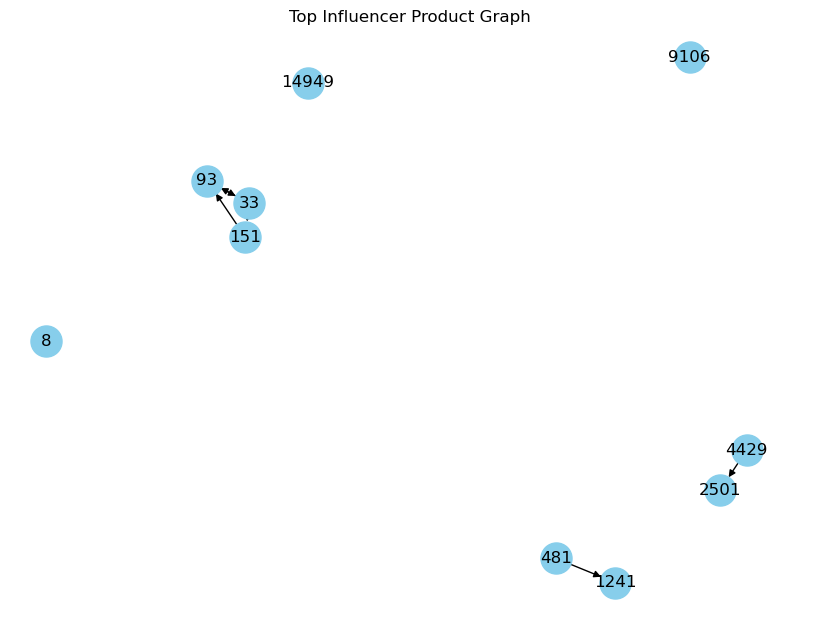

In [16]:
import matplotlib.pyplot as plt

# Ambil subset graph kecil buat visualize
H = G.subgraph(top_influencers_df["Product ID"].tolist())

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(H)
nx.draw(H, pos, with_labels=True, node_size=500, node_color='skyblue')
plt.title("Top Influencer Product Graph")
plt.show()


In [17]:
import google.generativeai as genai
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))
model = genai.GenerativeModel("gemini-1.5-pro")

def generate_business_insight(product_id, recommendations):
    rec_list = ", ".join(recommendations["Product ID"])
    prompt = f"Produk {product_id} sering dibeli bersama produk berikut: {rec_list}. Apa strategi pemasaran terbaik?"
    response = model.generate_content(prompt)
    return response.text


c:\Users\ACER\miniconda3\envs\kasdd\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# Dummy data buat test
product_id = "12345"
recommendations = pd.DataFrame({
    "Product ID": ["54321", "67890", "98765", "11121", "22232"]
})

def generate_business_insight(product_id, recommendations):
    rec_list = ", ".join(recommendations["Product ID"])
    prompt = f"Produk {product_id} sering dibeli bersama produk berikut: {rec_list}. Apa strategi pemasaran terbaik?"
    response = model.generate_content(prompt)
    return response.text

# Run
insight = generate_business_insight(product_id, recommendations)
print(insight)

Berikut beberapa strategi pemasaran yang bisa Anda gunakan, berdasarkan fakta bahwa produk 12345 sering dibeli bersama produk 54321, 67890, 98765, 11121, dan 22232:

**1. Bundling dan Penawaran Khusus:**

* **Bundel Produk:** Tawarkan bundel produk 12345 dengan salah satu atau beberapa produk yang sering dibeli bersamanya.  Misalnya, "Bundel Hemat: Produk 12345 + 54321" dengan harga diskon.
* **Diskon:** Berikan diskon khusus jika pelanggan membeli produk 12345 bersamaan dengan salah satu produk terkait.  Misalnya, "Beli produk 12345, dapatkan diskon 10% untuk produk 67890".
* **Promosi Silang:**  Tawarkan promosi beli 1 gratis 1 atau potongan harga untuk produk pelengkap saat pelanggan membeli produk 12345.

**2. Rekomendasi Produk (Product Recommendations):**

* **Website/E-commerce:** Tampilkan produk-produk terkait (54321, 67890, dst.) di halaman produk 12345 dengan label seperti "Sering Dibeli Bersama", "Pelanggan Juga Membeli", atau "Rekomendasi untuk Anda".
* **Email Marketing:*